In [ ]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tqdm import tqdm
import gc
from copy import deepcopy

import torch
import numpy as np
from torch import nn
import math
from models import *   
from v109 import *
from core import generate_default_model_name

In [ ]:
import torch
import numpy as np
torch.tensor(np.array([1,2,3.])).mean()

# inference

In [2]:
valid_dataset = []
for _ in range(100):
    # while True:
    env = create_env()
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>


100it [04:31,  2.72s/it]


110 0.0033333333333333335 0.99 54.42
<All keys matched successfully>


100it [04:39,  2.79s/it]


111 0.013333333333333334 0.95 55.2
<All keys matched successfully>


100it [04:30,  2.70s/it]

113 0.023333333333333334 0.93 52.98


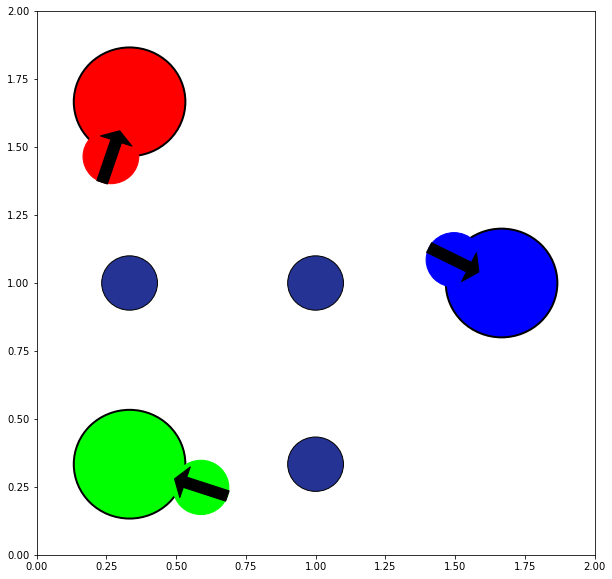

In [4]:
Env = DubinsCarEnv
env = DubinsCarEnv(num_agents=3, PROB=(0,0.1), SIZE=(8,8))

bnn = create_network()
bnn.eval();
for seem_good_idx in seem_good_idxs:
    print(bnn.load_state_dict(torch.load(f'model_gnn/dbgnn_DubinsCarEnv_v114_{seem_good_idx}.pt', map_location=device)))
    collideds = []
    dones = []
    lengths = []
    for v_idx, data in tqdm(enumerate(valid_dataset)):
        env = create_env()
        env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
        # env.world.agents[1:,:]=-100
        # env.world.obstacles = [[1.499, 1.499]]
        collided, done, gifs = infer(env,bnn,verbose=False,spatial_prop=False,stop_at_collision=True)
        save_gif(gifs, 'gifs/0416/v114/'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+f'_{seem_good_idx}.gif')
        collideds.append(collided)
        dones.append(done)
        lengths.append(len(gifs))

    print(seem_good_idx, np.mean(collideds), np.mean(dones), np.mean(lengths))    
# BMODEL_PATH
# BMODEL_PATH.replace('.pt', "_current.pt")
# BMODEL_PATH.replace('.pt', "_warmup.pt")
# BMODEL_PATH.replace('_'+version_name+'.pt', '_v22.pt')
# 'model_gnn/dbgnn_DubinsCarEnv13199_0.00.pt'
# 'model_gnn/dbgnn_DubinsCarEnv_v133999.pt'
# 'model_gnn/good_models/dbgnn_DubinsCarEnv_v114_66.pt'

<All keys matched successfully>


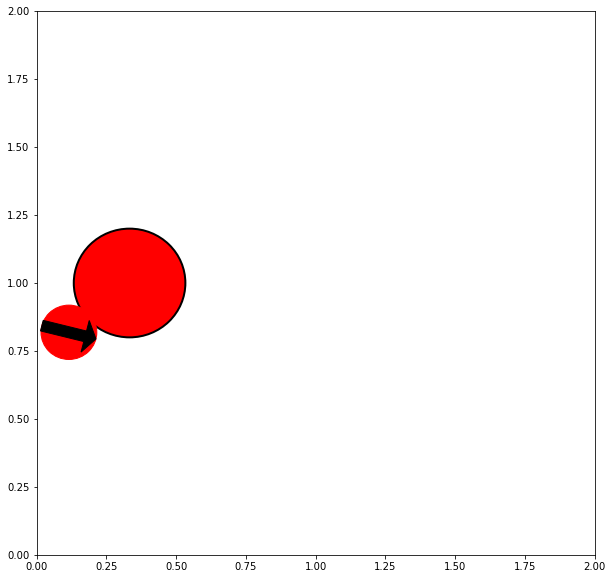

In [8]:
print(bnn.load_state_dict(torch.load(f'model_gnn/dbgnn_DubinsCarEnv_v114_110.pt', map_location=device)))
env = create_env(num_agents=1)
# env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
# env.world.agents[1:,:]=-100
env.world.obstacles = []
collided, done, gifs = infer(env,bnn,verbose=False,spatial_prop=False,stop_at_collision=True)
save_gif(gifs, 'gifs/0416/v114/gg.gif')

In [12]:
# NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = 8, 1.0, 4

valid_dataset = []
for _ in range(100):
    # while True:
    env = create_env()
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

In [ ]:
torch.flatten(torch.randn(2, 3), start_dim=-2)

100it [05:56,  3.56s/it]

0.02 0.94 53.72


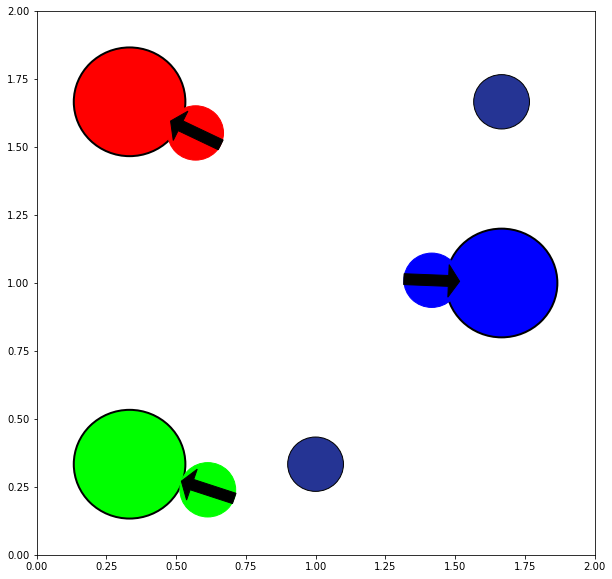

In [17]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env = create_env()
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    # env.world.agents[1:,:]=-100
    # env.world.obstacles = [[1.499, 1.499]]
    collided, done, gifs = infer(env,bnn,verbose=False,spatial_prop=False,stop_at_collision=True)
    save_gif(gifs, 'gifs/0416/v114/'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
%debug

In [ ]:
env._get_obs()['o_near_a']

In [ ]:
env.world.obstacles = np.array([[1.5, 1.5]])

In [ ]:
env.world.agent_goals

In [ ]:
from torch.utils.data import RandomSampler

class MyDataset(Dataset):
    def __init__(self, N):
        self.reset(N)
        
    def reset(self, N):
        self.N = N
        self.x = torch.rand(self.N, 10)
        self.y = torch.arange(self.N)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
ds = MyDataset(1)
sampler = RandomSampler(ds, replacement=True, num_samples=4)
dl = DataLoader(ds, batch_size=2, shuffle=True)
dl.sampler.replacement = False

In [ ]:
ds.reset(10)

In [ ]:
k = iter(dl)
for _ in range(10):
    if _ == 3:
        ds.reset(10)
    try:
        print(_, next(k))
    except StopIteration:
        k = iter(dl)
        print(_, next(k))

In [ ]:
env._render();

In [ ]:
%debug

In [ ]:
PE_DIM

In [ ]:
@torch.no_grad()
def infer(env, bnn, threshold=None, max_episode_length=256, verbose=False, seed=0, stop_at_collision=False, prop=None, need_gif=True):
    if prop is None:
        prop = PROP
    
    if threshold is None:
        threshold=THRESHOLD
    if verbose:
        print('----------------------------------------')
        
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    if need_gif:
        gifs = [env._render()]
    else:
        gifs = [None]
    total_trans=0; n_danger=0; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool)

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        a_refines, bvalues = eval_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = env.potential_field(a_refines, K1=K1, K2=K2, ignore_agent=True)
        
        v = np.zeros(env.num_agents)
        a = np.zeros((env.num_agents, env.action_dim))
        evil_agents = set()
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            
            feasible_current = False
            if np.any(bvalue>threshold):
                feasible_current = True
            else:
                feasible_current = False
            
            if feasible_current:
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        v[agent_id] = bvalue[a_idx]
                        break
                continue
            
            if prop:
                # find evil_agent
                local_o = o.clone()
                while True:
                    local_o.to('cpu')
                    edges = local_o['a_near_a'].edge_index
                    neighbor_edges = edges[1]==agent_id
                    if neighbor_edges.sum()==0:
                        break

                    first_edge = torch.where(neighbor_edges)[0][0]
                    mask = (torch.arange(edges.shape[1])==first_edge)
                    evil_agents.add(int(edges[0, first_edge]))
                    local_o['a_near_a'].edge_index = edges[:,~mask]
                    local_o['a_near_a'].edge_attr = local_o['a_near_a'].edge_attr[~mask,:]

                    local_a_refines, local_bvalues = eval_action(bnn, local_o, a_all, max_iter=0, threshold=threshold)          
                    # bvalues[agent_id] = bvalue = local_bvalues[agent_id]
                    # a_refine = local_a_refines[agent_id]

                    if np.any(local_bvalues>threshold):
                        break
            
            no_feasible += 1
            a[agent_id] = a_refine[np.argmax(bvalue)]
            v[agent_id] = bvalue[np.argmax(bvalue)]
                
        for evil_agent in evil_agents:
            a_refine, bvalue = a_refines[evil_agent], bvalues[evil_agent]
            a[evil_agent] = a_refine[np.argmax(bvalue)]
            v[evil_agent] = bvalue[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        
        prev_danger = info['prev_danger'].data.cpu().numpy().astype(bool)
        next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
        if np.any(next_danger):
            collided = collided | next_danger
        if verbose:
            print(total_trans, np.where(v<=threshold), next_danger, evil_agents)
            
        total_trans += 1
        if need_gif:
            gifs.append(env._render())
        else:
            gifs.append(None)

        if np.any(next_danger) and stop_at_collision:
            break        
        
        if done or (total_trans >= max_episode_length):
            break

    return collided, done, gifs

In [ ]:
env = create_env()
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(valid_dataset[17])
_, _, gifs = infer(env, bnn, verbose=True,prop=True,stop_at_collision=True)
save_gif(gifs, 'gifs/0406/v59/shit2.gif')

In [ ]:
env.initColors()[6]

In [ ]:
edges = env._get_obs()['a_near_a'].edge_index
edges[0,edges[1]==5]

In [ ]:
valid_dataset[17][1]

In [ ]:
o = env._get_obs()
o = o.clone()

evil_agents = []
while True:
    o.to('cpu')
    agent_id = 0
    edges = o['a_near_a'].edge_index
    neighbor_edges = edges[1]==agent_id
    if neighbor_edges.sum()==0:
        break
    
    first_edge = torch.where(neighbor_edges)[0][0]
    mask = (torch.arange(edges.shape[1])==first_edge)
    evil_agents.append(int(edges[0, first_edge]))
    o['a_near_a'].edge_index = edges[:,~mask]
    o['a_near_a'].edge_attr = o['a_near_a'].edge_attr[~mask,:]

    a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
    a_refines, bvalues = eval_action(bnn, o, a_all, max_iter=0, threshold=THRESHOLD)
    if (bvalues[0]>THRESHOLD).any():
        break

In [ ]:
neighbor_edges

In [ ]:
o['a_near_a'].edge_index 

In [ ]:
env.world.state

In [ ]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch_x = torch.tensor([0, 0, 0, 0])
y = torch.Tensor([[-1, 0], [1, 0]])
batch_y = torch.tensor([0, 0])
assign_index = knn(x, y, 2, batch_x, batch_y)

In [ ]:
assign_index

In [ ]:
from potential_field import infer_p
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer_p(env)
    save_gif(gifs, 'gifs/dubins_no_obstacle/128_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
data = valid_dataset[18]
env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
collided, done, gifs = infer(env, bnn, verbose=True)

In [ ]:
from potential_field import infer_p
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer_p(env, n_candidates=200, ignore_agent=False)
    save_gif(gifs, 'gifs/potential/dubins/128_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
from potential_field import infer_p
data = valid_dataset[2]
env = Env(num_agents=1, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
collided, done, gifs = infer_p(env, verbose=True)
save_gif(gifs, 'why.gif')

In [ ]:
%debug